# ECE 657A ASSIGNMENT 4
## Covid Dataset

###### Jubilee Imhanzenobe and Olohireme Ajayi

In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import plot_model

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# defining function for plotting correlation heatmap
def plot_heatmap(correlation, title):
    plt.figure(figsize=(15, 8))
    ax = sns.heatmap(correlation,annot=True,fmt='.3f',linewidths=0.3,annot_kws={"size": 18})
    plt.xticks(fontsize=12) 
    plt.yticks(fontsize=12) 
    plt.title(title, fontsize=20)
    ax.figure.axes[-1].tick_params(labelsize=18) # To increase fontsize of colorbar ticks
    #lim = len(correlation.columns)
    #ax.set_ylim([0,lim]) # to make the map display correctly without trimming the edges
    plt.show()
    return

In [4]:
def accuracy_loss_plot(history):
    plt.Figure()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()
    plt.Figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='lower right')
    plt.show()

In [5]:
def print_accuracy(model, y_train, y_val, y_test):    
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    
    preds = [y_pred_train, y_pred_val, y_pred_test]
    trues = [y_train, y_val, y_test]
    
    tag = ['Train', 'Val', 'Test']
    
    for i in range(3):
        y_pred = preds[i]
        pred = []
        for j in range(len(y_pred)):
            pred.append(np.argmax(y_pred[j]))

        #Converting one hot encoded test label to label
        y_true = trues[i]
        true = []
        for j in range(len(y_true)):
            true.append(np.argmax(y_true[j]))

        accuracy = accuracy_score(true, pred)
        print(tag[i], 'Set Accuracy:\t', accuracy * 100)

In [6]:
# importing the dataset
dataset = pd.read_csv('COVID_dataset.csv')

In [7]:
dataset.shape

(14860, 12)

In [8]:
dataset.head(10)

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,2020-03-30,2020-03-31,2020-03-31,2020-03-30,70s,MALE,OB,Stratford,Yes,43.368662,-81.001913,Fatal
1,2021-01-22,2021-01-24,2021-01-24,2021-01-23,50s,FEMALE,NO KNOWN EPI LINK,Newmarket,NaN,44.048023,-79.480239,Not Resolved
2,2020-03-24,2020-04-14,2020-04-14,2020-04-13,70s,FEMALE,OB,Toronto,Yes,43.656591,-79.379358,Resolved
3,2021-01-18,2021-01-21,2021-01-21,2021-01-18,<20,MALE,CC,Mississauga,NaN,43.647471,-79.708893,Not Resolved
4,2020-12-26,2020-12-28,2020-12-28,2020-12-26,60s,MALE,OB,Windsor,Yes,42.308796,-83.033670,Resolved
5,2021-01-17,2021-01-19,2021-01-19,2021-01-18,50s,FEMALE,CC,Mississauga,NaN,43.647471,-79.708893,Not Resolved
6,2021-01-23,2021-01-24,2021-01-24,2021-01-23,20s,MALE,MISSING INFORMATION,Ottawa,NaN,45.345665,-75.763912,Not Resolved
7,2021-01-06,2021-01-20,2021-01-20,2021-01-19,80s,FEMALE,OB,Waterloo,Yes,43.462876,-80.520913,Resolved
8,2021-01-25,2021-01-29,2021-01-29,2021-01-28,40s,MALE,CC,Newmarket,NaN,44.048023,-79.480239,Not Resolved
9,2020-12-07,2020-12-11,2020-12-11,2020-12-07,90s,MALE,OB,Hamilton,Yes,43.257631,-79.871341,Fatal


## Data Cleaning

In [9]:
# checking for missing values in columns
for column in dataset.columns:
    print(column, "-", dataset[column].isna().sum())

Accurate_Episode_Date - 0
Case_Reported_Date - 0
Test_Reported_Date - 203
Specimen_Date - 122
Age_Group - 5
Client_Gender - 0
Case_AcquisitionInfo - 0
Reporting_PHU_City - 0
Outbreak_Related - 9082
Reporting_PHU_Latitude - 0
Reporting_PHU_Longitude - 0
Outcome1 - 0


In [10]:
# filling missing values in outbreak related with NO
dataset["Outbreak_Related"].fillna("No", inplace=True)

In [11]:
# drop missing columns in Age_Group
dataset = dataset[dataset['Age_Group'].notna()]
dataset.reset_index(drop=True, inplace=True)

In [12]:
data = dataset[dataset['Case_Reported_Date'] == dataset['Test_Reported_Date']]
data.shape

(13757, 12)

In [13]:
# grouping features accourding to their data types
dates = ['Accurate_Episode_Date', 'Case_Reported_Date', 'Test_Reported_Date', 'Specimen_Date']
cats = ['Client_Gender','Case_AcquisitionInfo','Reporting_PHU_City','Outbreak_Related']
nums = ['Reporting_PHU_Latitude', 'Reporting_PHU_Longitude']
ords = ['Age_Group']
target = ['Outcome1']

In [14]:
# inspecting the unique values in categorical columns and their frequencies
for column in cats:
    print(column)
    print(dataset[column].value_counts())
    print()

Client_Gender
FEMALE            7559
MALE              7192
UNSPECIFIED        103
GENDER DIVERSE       1
Name: Client_Gender, dtype: int64

Case_AcquisitionInfo
OB                      5369
CC                      4121
MISSING INFORMATION     2928
NO KNOWN EPI LINK       2240
TRAVEL                   192
UNSPECIFIED EPI LINK       5
Name: Case_AcquisitionInfo, dtype: int64

Reporting_PHU_City
Toronto             5136
Mississauga         2450
Newmarket           1242
Ottawa               773
Windsor              593
Thorold              571
Whitby               565
Hamilton             523
Waterloo             491
Oakville             465
London               411
Barrie               358
Guelph               256
Cornwall             166
St. Thomas           113
Point Edward          87
Stratford             82
Simcoe                75
Thunder Bay           72
Chatham               65
Brockville            62
Port Hope             58
Brantford             43
Sudbury               40
Tim

In [15]:
# Assigning numeric labels to ordinal data for data exploration
dataset['Age_Group'].replace(["<20", "20s", "30s", "40s", "50s", "60s", "70s", "80s", "90s"],[0,1,2,3,4,5,6,7,8], inplace = True)

In [16]:
# Label encoding the outcomes
outcomes = ["Resolved", "Not Resolved", "Fatal"]
dataset['Outcome1'].replace(["Resolved", "Not Resolved", "Fatal"],[0,1,2], inplace = True)

In [17]:
dataset['Case_Reported_Date'].dtype

dtype('O')

In [18]:
# convert the dates from float to datetime objects
for column in dates:
    dataset[column] = pd.to_datetime(dataset[column], format = '%Y-%m-%dT', errors = 'coerce')

In [19]:
dataset.head()

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,2020-03-30,2020-03-31,2020-03-31,2020-03-30,6,MALE,OB,Stratford,Yes,43.368662,-81.001913,2
1,2021-01-22,2021-01-24,2021-01-24,2021-01-23,4,FEMALE,NO KNOWN EPI LINK,Newmarket,No,44.048023,-79.480239,1
2,2020-03-24,2020-04-14,2020-04-14,2020-04-13,6,FEMALE,OB,Toronto,Yes,43.656591,-79.379358,0
3,2021-01-18,2021-01-21,2021-01-21,2021-01-18,0,MALE,CC,Mississauga,No,43.647471,-79.708893,1
4,2020-12-26,2020-12-28,2020-12-28,2020-12-26,5,MALE,OB,Windsor,Yes,42.308796,-83.033670,0


## Exploratrory Data Analysis

##### Plotting the pairs plot for numeric features

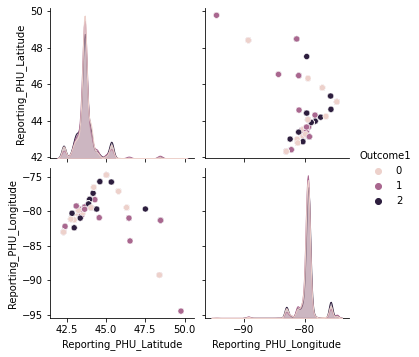

In [20]:
sns.pairplot(dataset[['Reporting_PHU_Latitude', 'Reporting_PHU_Longitude', 'Outcome1']], hue="Outcome1")

#### Checking the correlation for numerical features

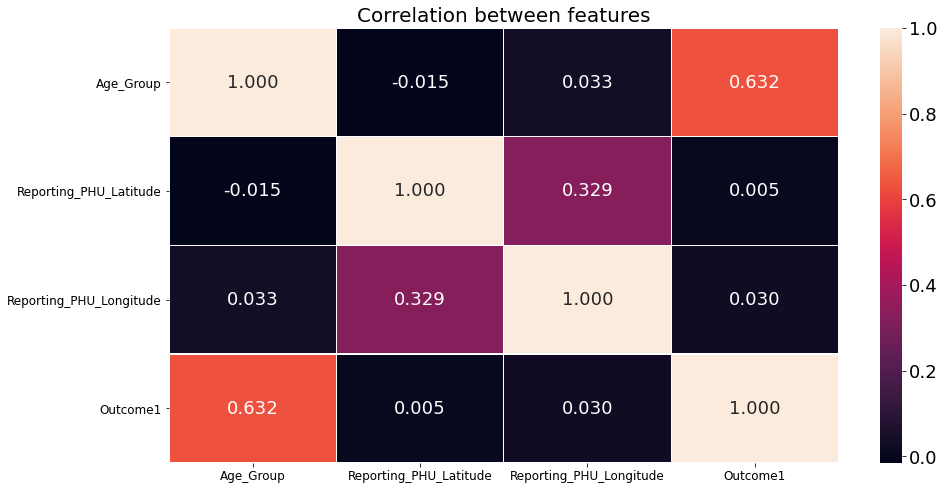

In [21]:
plot_heatmap(dataset.corr(), 'Correlation between features')

### <span style="color:blue">Observations from correlation heatmap of numeric and ordinal features </span> 

- Age group has the highest positive correlation with the outcome (0.632)
- latitude and longitude have low correlation with the outcome.

### Checking the correlations of categorical features using Cramer's V method

Cramér’s V is substitute for correlation which is suitable for categorical variables. It is based on a nominal variation of Pearson’s Chi-Square Test.

1. Just like correlation, the output is in the range of [0,1], where 0 means no association and 1 is full association. (Unlike correlation, there are no negative values, as there’s no such thing as a negative association. Either there is, or there isn’t).

2. Like correlation, Cramer’s V is symmetrical — it is insensitive to swapping x and y

In [22]:
import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [23]:
for column1 in cats:
    print(column1, '-', 'Outcome = ', round(cramers_v(dataset[column1], dataset['Outcome1']), 3))
    for column2 in cats:
        print(column1, '-', column2, '=', round(cramers_v(dataset[column1], dataset[column2]), 3))
    print()

Client_Gender - Outcome =  0.021
Client_Gender - Client_Gender = 1.0
Client_Gender - Case_AcquisitionInfo = 0.063
Client_Gender - Reporting_PHU_City = 0.038
Client_Gender - Outbreak_Related = 0.107

Case_AcquisitionInfo - Outcome =  0.416
Case_AcquisitionInfo - Client_Gender = 0.063
Case_AcquisitionInfo - Case_AcquisitionInfo = 1.0
Case_AcquisitionInfo - Reporting_PHU_City = 0.261
Case_AcquisitionInfo - Outbreak_Related = 0.919

Reporting_PHU_City - Outcome =  0.15
Reporting_PHU_City - Client_Gender = 0.038
Reporting_PHU_City - Case_AcquisitionInfo = 0.261
Reporting_PHU_City - Reporting_PHU_City = 1.0
Reporting_PHU_City - Outbreak_Related = 0.206

Outbreak_Related - Outcome =  0.535
Outbreak_Related - Client_Gender = 0.107
Outbreak_Related - Case_AcquisitionInfo = 0.919
Outbreak_Related - Reporting_PHU_City = 0.206
Outbreak_Related - Outbreak_Related = 1.0



### <span style="color:blue">Observations from Cramer's V coefficients of categorical features </span> 

- Outbreak Related has a the most significant relationship with the outcome (0.535).
- Case_AcquisitionInfo also has a significant relationship with the outcome (0.416).
- Client Gender has the least correlation with the outcome.
- Case_AcquisitionInfo and Outbreak Related have the highest inter-feature relationship (0.919) which is logical as they both describe how the virus was contacted.

##### Calculating the mean, variance, skew, kurtosis for the datasets

In [24]:
# comparing for the different outcomeget
for outcome in dataset["Outcome1"].unique():
    print("*** Outcome = ", outcomes[outcome], "***")
    columns = nums + ords
    for column in columns:
        
        mean = round(dataset[dataset['Outcome1'] == outcome][column].mean(), 2)
        variance = round(dataset[dataset['Outcome1'] == outcome][column].var(), 2)
        skew = round(dataset[dataset['Outcome1'] == outcome][column].skew(), 2)
        kurtosis = round(dataset[dataset['Outcome1'] == outcome][column].kurt(), 2)
        
        # if column is not numeric find the mode
        if column in cats or column in ords:
            mode = round(dataset[dataset['Outcome1'] == outcome][column].mode()[0], 2)
            print(column, "Mode -", mode)
        else:
            print(column, "Mean -", mean)
            
        print(column, "Variance -", variance)
        print(column, "Skew -", skew)
        print(column, "Kurtosis -", kurtosis)
        print()

*** Outcome =  Fatal ***
Reporting_PHU_Latitude Mean - 43.72
Reporting_PHU_Latitude Variance - 0.55
Reporting_PHU_Latitude Skew - 2.01
Reporting_PHU_Latitude Kurtosis - 9.81

Reporting_PHU_Longitude Mean - -79.48
Reporting_PHU_Longitude Variance - 2.63
Reporting_PHU_Longitude Skew - -0.31
Reporting_PHU_Longitude Kurtosis - 6.4

Age_Group Mode - 7
Age_Group Variance - 1.33
Age_Group Skew - -1.19
Age_Group Kurtosis - 1.97

*** Outcome =  Not Resolved ***
Reporting_PHU_Latitude Mean - 43.75
Reporting_PHU_Latitude Variance - 0.62
Reporting_PHU_Latitude Skew - 3.23
Reporting_PHU_Latitude Kurtosis - 16.73

Reporting_PHU_Longitude Mean - -79.63
Reporting_PHU_Longitude Variance - 2.41
Reporting_PHU_Longitude Skew - -1.84
Reporting_PHU_Longitude Kurtosis - 19.26

Age_Group Mode - 1
Age_Group Variance - 4.52
Age_Group Skew - 0.5
Age_Group Kurtosis - -0.55

*** Outcome =  Resolved ***
Reporting_PHU_Latitude Mean - 43.72
Reporting_PHU_Latitude Variance - 0.48
Reporting_PHU_Latitude Skew - 2.5
Repo

###  <span style="color:blue"> Nature of the data and observations </span>

- The most frequently occuring age group in the Resolved and Not Resolved Outcomes is 20s, while the mode age group for the Fatal Outcome is 80s.
- The mean latitude and longitude for all outcomes are similar.
- for all outcomes, Longitude is left skewed while Latitude is right skewed.

In [25]:
# Assigning numeric labels to categorical data for data exploration
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

data = dataset.copy()
for column in cats:
    data[column] = le.fit_transform(data[column])

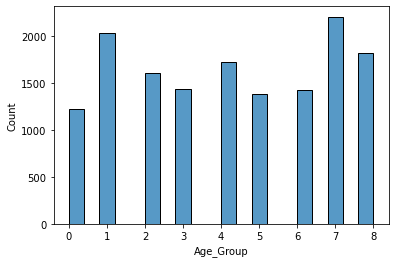

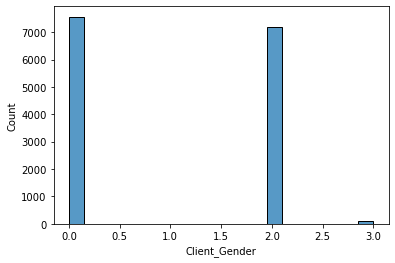

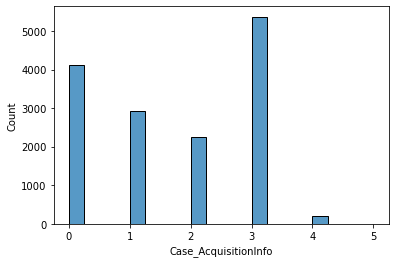

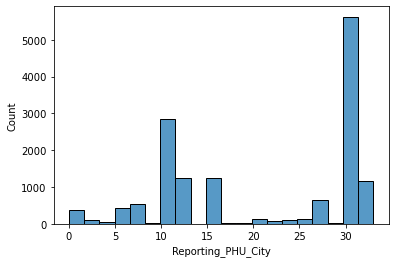

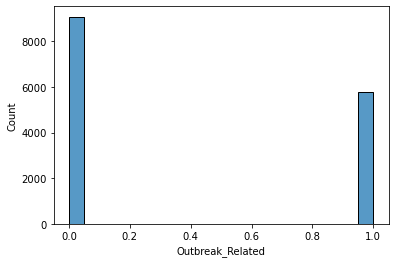

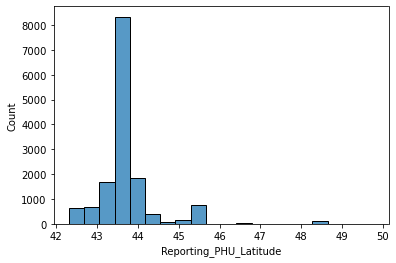

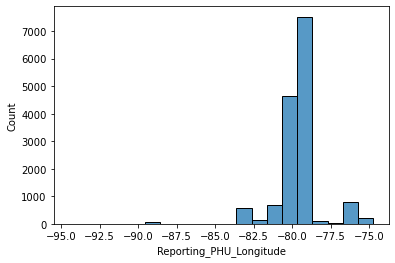

In [26]:
# Plotting histogram to view data distribution
for column in data.iloc[:,4:-1].columns:
    plt.figure()
    sns.histplot(data = data, x = column, bins = 20)
    plt.show()

### <span style="color:blue">Notes about Histogram</span>

- All categorical variables are in the right range without outliers.
- Reporting_PHU_Latitude and Reporting_PHU_Longitude both seem to have outliers.

#### Plotting histogram grouped by the different outcomes

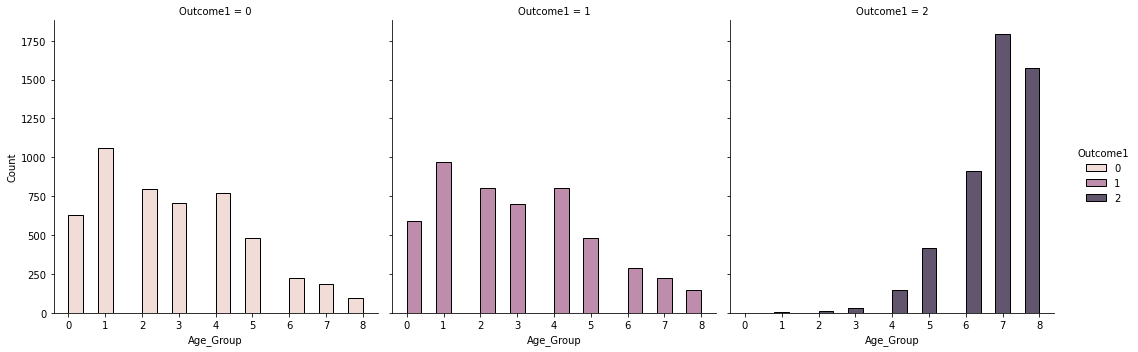

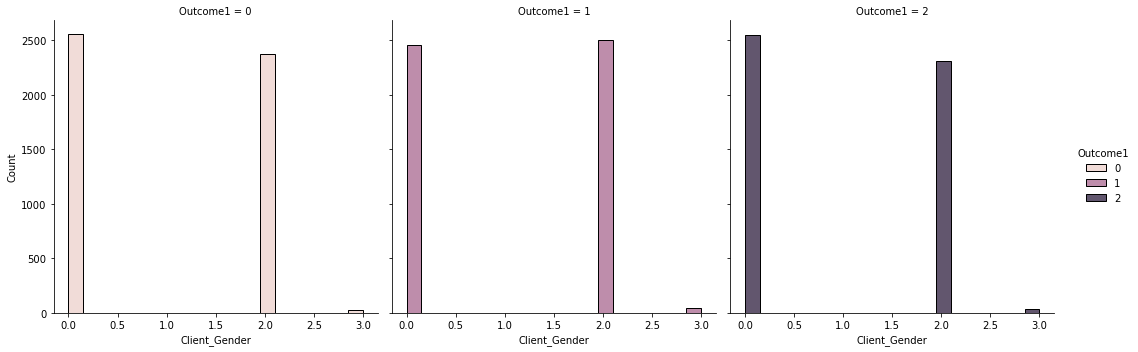

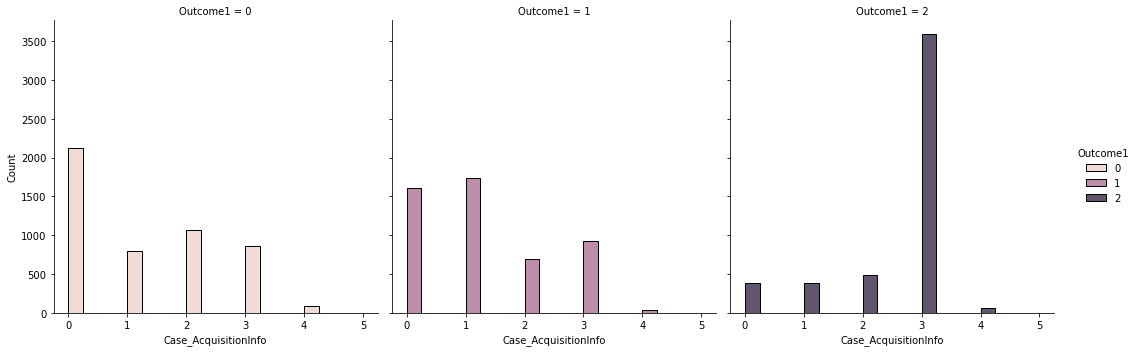

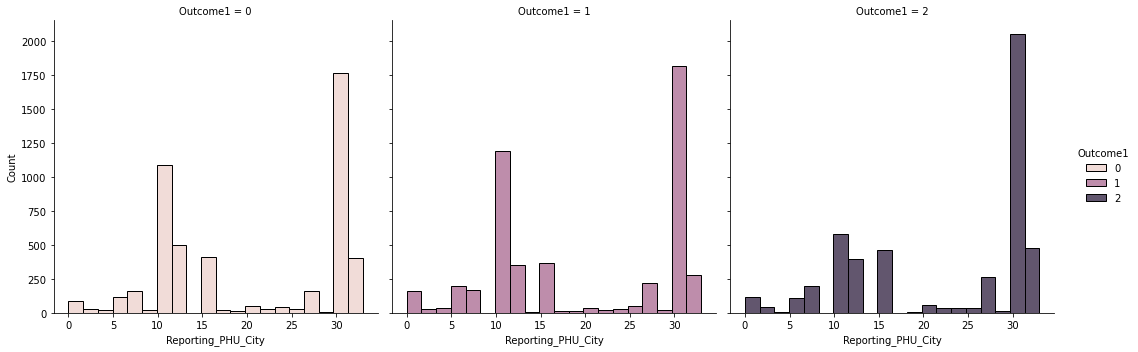

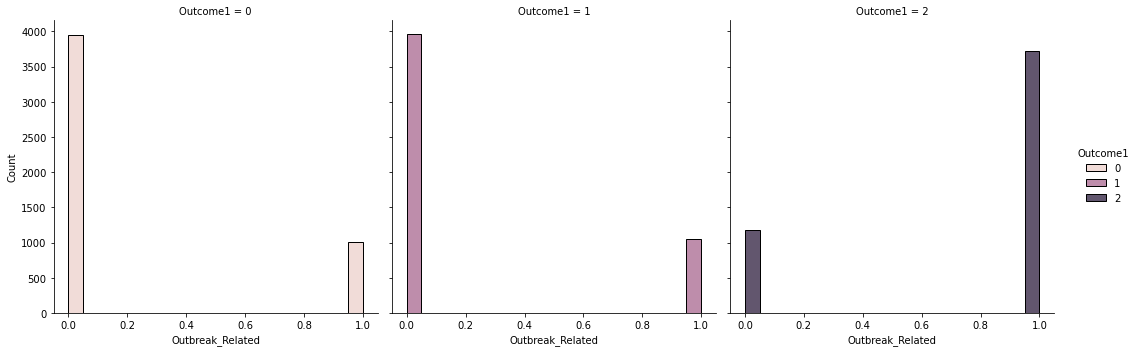

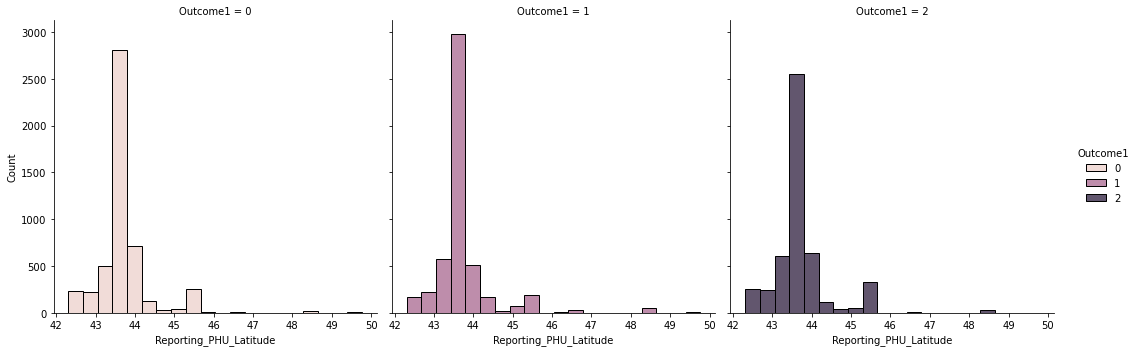

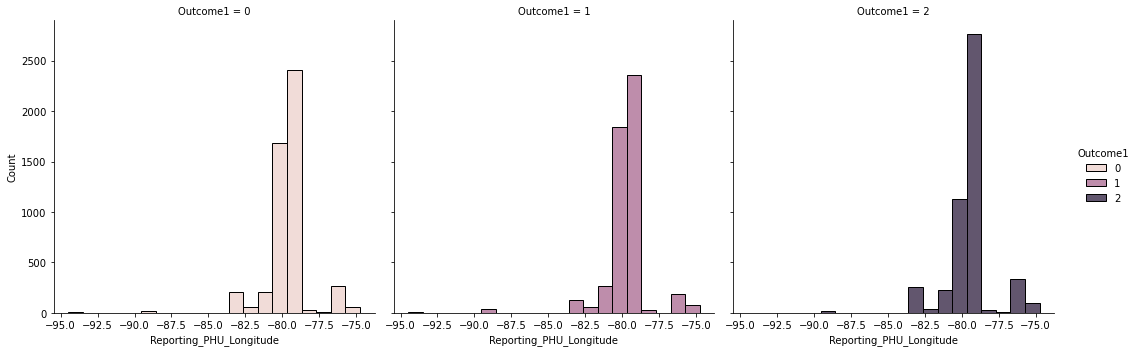

In [27]:
# plotting the histogram to view data distribution by outcome
for feature in data.columns[4:-1]:
    sns.displot(data, x = feature, bins = 20, col = 'Outcome1', hue = 'Outcome1')

#### <span style="color:blue">Nature of the data and observations</span>

- For Age Group, most of people older than 70 have a fatal outcome while most people less than 40 have either Resolced or Unresolved outcomes.
- The distributions for Client Gender, Outbreak Related and Reporting_PHU_City are very similar for all three Outcomes
- In the Case Acquisition Info, most of the causes caused by outbreak resulted in a fatal outcome.
- Most cases which were outbreak related had a fatal outcome.

In [28]:
dataset.head()

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,2020-03-30,2020-03-31,2020-03-31,2020-03-30,6,MALE,OB,Stratford,Yes,43.368662,-81.001913,2
1,2021-01-22,2021-01-24,2021-01-24,2021-01-23,4,FEMALE,NO KNOWN EPI LINK,Newmarket,No,44.048023,-79.480239,1
2,2020-03-24,2020-04-14,2020-04-14,2020-04-13,6,FEMALE,OB,Toronto,Yes,43.656591,-79.379358,0
3,2021-01-18,2021-01-21,2021-01-21,2021-01-18,0,MALE,CC,Mississauga,No,43.647471,-79.708893,1
4,2020-12-26,2020-12-28,2020-12-28,2020-12-26,5,MALE,OB,Windsor,Yes,42.308796,-83.033670,0


In [29]:
df = pd.get_dummies(dataset.iloc[:,:-1], columns = cats, drop_first = True)
df["Outcome1"] = dataset["Outcome1"]
dataset = df

dataset.head()

,Accurate_Episode_Date,Case_Reported_Date,Test_Reported_Date,Specimen_Date,Age_Group,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Client_Gender_GENDER DIVERSE,Client_Gender_MALE,Client_Gender_UNSPECIFIED,...,Reporting_PHU_City_Sudbury,Reporting_PHU_City_Thorold,Reporting_PHU_City_Thunder Bay,Reporting_PHU_City_Timmins,Reporting_PHU_City_Toronto,Reporting_PHU_City_Waterloo,Reporting_PHU_City_Whitby,Reporting_PHU_City_Windsor,Outbreak_Related_Yes,Outcome1
0,2020-03-30,2020-03-31,2020-03-31,2020-03-30,6,43.368662,-81.001913,0,1,0,...,0,0,0,0,0,0,0,0,1,2
1,2021-01-22,2021-01-24,2021-01-24,2021-01-23,4,44.048023,-79.480239,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2020-03-24,2020-04-14,2020-04-14,2020-04-13,6,43.656591,-79.379358,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,2021-01-18,2021-01-21,2021-01-21,2021-01-18,0,43.647471,-79.708893,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,2020-12-26,2020-12-28,2020-12-28,2020-12-26,5,42.308796,-83.033670,0,1,0,...,0,0,0,0,0,0,0,1,1,0


In [30]:
df = dataset.iloc[:,4:]
df.head()

,Age_Group,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Client_Gender_GENDER DIVERSE,Client_Gender_MALE,Client_Gender_UNSPECIFIED,Case_AcquisitionInfo_MISSING INFORMATION,Case_AcquisitionInfo_NO KNOWN EPI LINK,Case_AcquisitionInfo_OB,Case_AcquisitionInfo_TRAVEL,...,Reporting_PHU_City_Sudbury,Reporting_PHU_City_Thorold,Reporting_PHU_City_Thunder Bay,Reporting_PHU_City_Timmins,Reporting_PHU_City_Toronto,Reporting_PHU_City_Waterloo,Reporting_PHU_City_Whitby,Reporting_PHU_City_Windsor,Outbreak_Related_Yes,Outcome1
0,6,43.368662,-81.001913,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,2
1,4,44.048023,-79.480239,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,6,43.656591,-79.379358,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,0,43.647471,-79.708893,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,42.308796,-83.033670,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0


In [31]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values.reshape(-1, 1)

from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y = ohe.fit_transform(y).toarray()

In [32]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 0)

In [33]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

In [34]:
X_train.shape

(11884, 45)

In [35]:
y_train.shape

(11884, 3)

#### Model 1

In [50]:
%%capture
model = Sequential()

# Creating the input layer and first hidden layer
model.add(Dense(16, input_dim=45, activation='relu'))

#Adding second hidden layer
model.add(Dense(12, activation='relu'))

#Adding the output layer
model.add(Dense(3, activation='softmax'))

#Compiling the ANN
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Fitting the classifier to the training set
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=128, epochs=100)

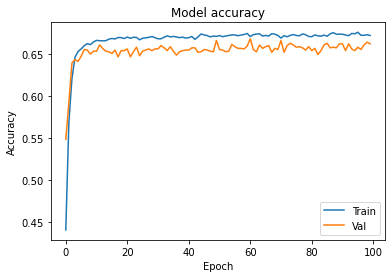

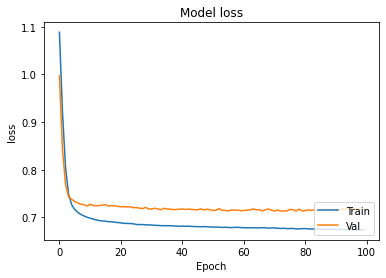

In [51]:
accuracy_loss_plot(history)

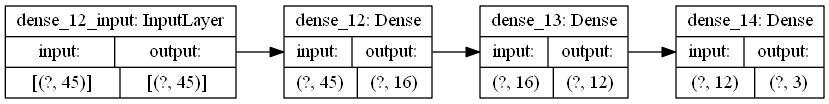

In [52]:
plot_model(model, show_shapes=True, rankdir="LR")

In [89]:
print(model.summary())

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128)               89088     
_________________________________________________________________
dense_54 (Dense)             (None, 12)                1548      
_________________________________________________________________
dense_55 (Dense)             (None, 3)                 39        
Total params: 90,675
Trainable params: 90,675
Non-trainable params: 0
_________________________________________________________________
None


In [53]:
print_accuracy(model, y_train, y_val, y_test)

Train Set Accuracy:	 67.62032985526758
Val Set Accuracy:	 66.26262626262627
Test Set Accuracy:	 67.56393001345896


#### Model 2

In [81]:
%%capture
model = Sequential()

# Creating the input layer and first hidden layer
model.add(Dense(16, input_dim=45, activation='sigmoid'))

#Adding second hidden layer
model.add(Dense(12, activation='sigmoid'))

#Adding the output layer
model.add(Dense(3, activation='softmax'))

#Compiling the ANN
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Fitting the classifier to the training set
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=128, epochs=100)

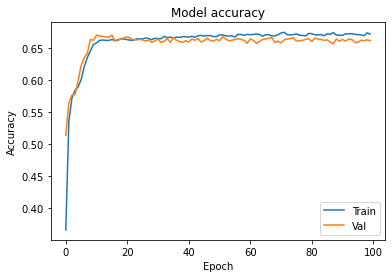

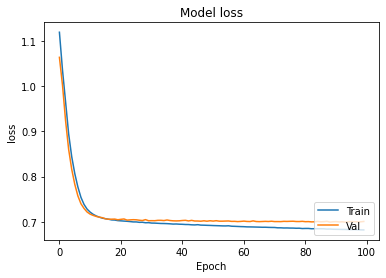

In [82]:
accuracy_loss_plot(history)

In [83]:
print_accuracy(model, y_train, y_val, y_test)

Train Set Accuracy:	 67.15752271962302
Val Set Accuracy:	 66.12794612794613
Test Set Accuracy:	 68.10228802153432


#### Model 3

In [109]:
%%capture
from keras.layers import SimpleRNN, LSTM
model = Sequential()

# Creating the input layer and first hidden layer
model.add(LSTM(128, input_shape=(1188,45)))

#Adding second hidden layer
model.add(Dense(12, activation='sigmoid'))

#Adding the output layer
model.add(Dense(3, activation='softmax'))

model.build()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=1188, epochs=100)
"""
#Compiling the ANN
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Fitting the classifier to the training set
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size=128, epochs=100)"""

ValueError: in user code:

    C:\Users\jubil\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\jubil\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\jubil\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\jubil\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\jubil\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\jubil\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\jubil\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\jubil\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\jubil\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential_40 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 45]


In [107]:
y_val.shape

(1485, 3)

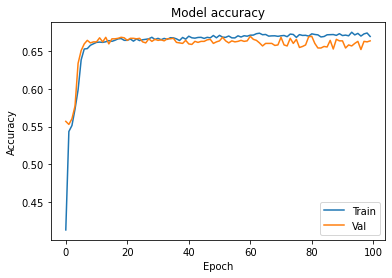

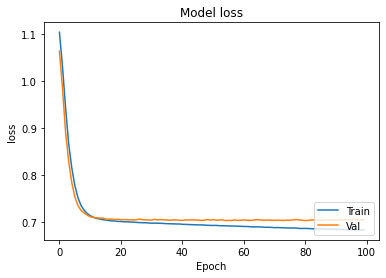

In [61]:
accuracy_loss_plot(history)

In [62]:
print_accuracy(model, y_train, y_val, y_test)

Train Set Accuracy:	 67.27532817233255
Val Set Accuracy:	 66.32996632996633
Test Set Accuracy:	 67.29475100942126
